In [1]:
!ipython kernel install --user --name=throne_trader_venv

Installed kernelspec throne_trader_venv in /Users/vicky/Library/Jupyter/kernels/throne_trader_venv


In [2]:
!pip install -qU --upgrade pip
!pip install -qU numpy pandas tensorflow scikit-learn yfinance

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

### Import required modules

In [3]:
import os
from datetime import datetime, timedelta
from typing import Any, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # TensorFlow to only display warning messages (level 2) and higher

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [4]:
SCALER = MinMaxScaler(feature_range=(0, 1))

In [5]:
def get_historical_data(symbol: str,
                        years: int = 1) -> Union[List[Tuple[str, float]], pd.DataFrame]:
    print(f"Downloading stock data for {symbol} for {years} years.")
    start = (datetime.now() - timedelta(days=years * 365)).strftime("%Y-%m-%d")
    end = datetime.now().strftime("%Y-%m-%d")
    stock_data = yfinance.download(symbol, start=start, end=end)
    return stock_data

In [6]:
def prepare_data(data: pd.DataFrame,
                 look_back: int = 7) -> Tuple[np.ndarray, np.ndarray]:
    scaled_data = SCALER.fit_transform(data['Close'].values.reshape(-1, 1))

    x_axis, y_axis = [], []
    for i in range(len(scaled_data) - look_back):
        x_axis.append(scaled_data[i:i + look_back])
        y_axis.append(scaled_data[i + look_back])

    x_axis, y_axis = np.array(x_axis), np.array(y_axis)
    x_axis = np.reshape(x_axis, (x_axis.shape[0], x_axis.shape[1], 1))

    return x_axis, y_axis

In [7]:
def build_lstm_model(input_shape: Tuple[Any, int]) -> Sequential:
    sequential = Sequential()
    sequential.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    sequential.add(LSTM(units=50))
    sequential.add(Dense(1))
    sequential.compile(optimizer='adam', loss='mean_squared_error')
    return sequential

### Set ticker, epoch size and batch size

In [8]:
TICKER = "GOOGL"
EPOCH_SIZE = 100
BATCH_SIZE = 32

### Download training and validation dataset

In [9]:
training_dataset = get_historical_data(symbol=TICKER, years=5)
validation_dataset = get_historical_data(symbol=TICKER, years=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Prepare the data, build and train the LSTM model using the training dataset

In [10]:
# Prepare the data
x, y = prepare_data(data=training_dataset)

# Build the LSTM model
model = build_lstm_model(input_shape=(x.shape[1], 1))

# Train the model on the entire historical dataset
model.fit(x, y, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/100
40/40 [==============================] - 2s 5ms/step - loss: 0.0401
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 8/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 13/100
40/40 [=================

40/40 [==============================] - 0s 5ms/step - loss: 3.9078e-04
Epoch 99/100
40/40 [==============================] - 0s 5ms/step - loss: 4.9178e-04
Epoch 100/100
40/40 [==============================] - 0s 5ms/step - loss: 3.8412e-04


### Use the trained model to predict future stock prices

In [11]:
# Evaluate the model's predictive capability in a realistic scenario where it encounters new, unseen data
future_x, _ = prepare_data(validation_dataset)

# Make predictions for the future period
future_predictions = model.predict(future_x)

8/8 [==============================] - 1s 2ms/step


In [12]:
# Inverse transform the predictions to get the actual stock prices.
SCALER.fit(training_dataset['Close'].values.reshape(-1, 1))
transformed_future_predictions = SCALER.inverse_transform(future_predictions)

# Extract future dates for the validation period
future_dates = pd.date_range(start=training_dataset.index[-1],
                             periods=len(transformed_future_predictions))

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
future_prices = pd.Series(data=transformed_future_predictions[:, 0], index=future_dates)
future_prices

2023-08-11    113.028664
2023-08-12    112.067001
2023-08-13    111.817673
2023-08-14    117.003731
2023-08-15    106.285843
2023-08-16    102.922905
2023-08-17    101.854630
2023-08-18    100.669952
2023-08-19    102.864128
2023-08-20    100.266571
2023-08-21     97.694878
2023-08-22    101.299782
2023-08-23    100.668686
2023-08-24    103.943329
2023-08-25    105.100616
2023-08-26     94.714378
2023-08-27     93.376335
2023-08-28     90.417389
2023-08-29     89.451767
2023-08-30     89.639381
2023-08-31     86.888092
2023-09-01     83.267090
2023-09-02     83.226921
2023-09-03     81.527115
2023-09-04     80.124153
2023-09-05     78.743835
2023-09-06     81.367889
2023-09-07     79.311600
2023-09-08     76.089935
2023-09-09     78.321678
2023-09-10     83.424416
2023-09-11     85.376709
2023-09-12     85.809174
2023-09-13     82.164246
2023-09-14     79.692169
2023-09-15     78.114639
2023-09-16     78.072601
2023-09-17     79.972588
2023-09-18     77.706451
2023-09-19     80.701027


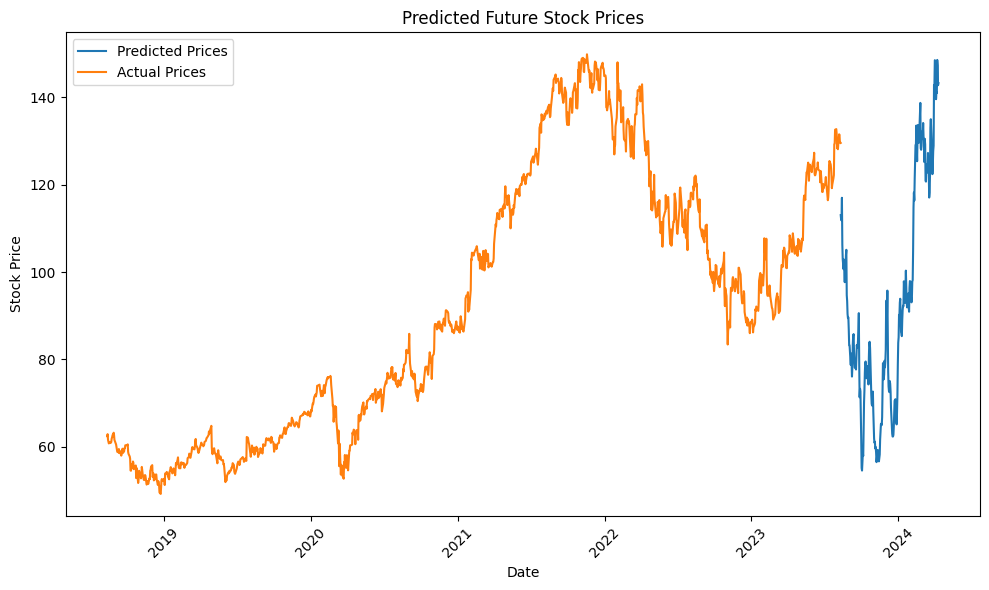

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(future_prices.index, future_prices.values, label="Predicted Prices")
actual_data = pd.Series(training_dataset['Close'])
plt.plot(actual_data.index, actual_data.values, label="Actual Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Predicted Future Stock Prices")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()